In [38]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import re
import copy
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
from einops import rearrange

import torch
from torch import nn
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

from src.utils import *

### Configs

In [39]:
# Sampling Config
mode_list = 'original, erase, retain'
guidance_scale = 7.5
bs = 2 # num of generated images per prompt
total_timesteps = 30 # The total timesteps of the sampling process
decomp_timestep = 0 # The decomp calculation will keep until this hyper-parameter
seed = 0

# Erasing Config
target_concept = 'Van Gogh' # concept to be erased
contents = 'A night scene in Van Gogh style.' # the prompt for image generation
token_sim = True # whether to enable the adaptive earsing shift
sigmoid_a = 100 # p
sigmoid_b = 0.93 # epsilon
sigmoid_c = 2 # s
record_type = 'values'

### Load T2I Diffusion Models

In [ ]:
pipe = DiffusionPipeline.from_pretrained("Compvis/stable-diffusion-v1-4", safety_checker=None, torch_dtype=torch.float16).to('cuda') 
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
unet, tokenizer, text_encoder, vae = pipe.unet, pipe.tokenizer, pipe.text_encoder, pipe.vae
if 'original' in mode_list: unet_original = copy.deepcopy(unet) # generate image with original SD
if 'erase' in mode_list: unet_erase = copy.deepcopy(unet) # visulize the erased component
if 'retain' in mode_list: unet_retain = copy.deepcopy(unet) # generated image wih AdaVD

### Token-wise Target Embedding Pre-processing

In [41]:
mode_list = mode_list.replace(' ', '').split(',')
target_concepts = [item.strip() for item in target_concept.split(',')]
target_concept_encodings_ = [get_textencoding(get_token(concept, tokenizer), text_encoder) for concept in target_concepts]
target_eot_idxs = [get_eot_idx(get_token(concept, tokenizer)) for concept in target_concepts]
target_concept_encoding = [get_spread_embedding(target_concept_encoding_, idx) for (target_concept_encoding_, idx) in zip(target_concept_encodings_, target_eot_idxs)]
target_concept_encoding = torch.concat(target_concept_encoding)
uncond_encoding = get_textencoding(get_token('', tokenizer), text_encoder)

### AdaVD: Adaptive Value Decomposition

In [42]:
class VisualAttentionProcess(nn.Module):

    def __init__(self, module_name=None, atten_type='original', target_records=None, record=False, 
    record_type=None, sigmoid_setting=None, token_sim=False, decomp_timestep=0,  **kwargs):
        super().__init__()
        self.module_name = module_name
        self.atten_type = atten_type
        self.target_records  = target_records
        self.record = record
        self.record_type = record_type
        self.sigmoid_setting = sigmoid_setting
        self.token_sim = token_sim
        self.decomp_timestep = decomp_timestep

    def __call__(self, attn, hidden_states, encoder_hidden_states, *args, **kwargs):
        attn._modules.pop("processor")
        attn.processor = AttnProcessor(self.module_name, self.atten_type, self.target_records, self.record, self.record_type, self.sigmoid_setting, self.token_sim, self.decomp_timestep)
        return attn.processor(attn, hidden_states, encoder_hidden_states, *args, **kwargs)
    

class AttnProcessor():

    def __init__(self, module_name=None, atten_type='original', target_records=None, record=False, record_type=None, sigmoid_setting=None, token_sim=False, decomp_timestep=0) -> None:
        self.module_name = module_name
        self.atten_type = atten_type
        self.target_records = copy.copy(target_records)
        self.record = record
        self.record_type = record_type.strip().split(',') if record_type is not None else []
        self.records = {key: {} for key in self.record_type} if record_type is not None else {}
        self.sigmoid_setting = sigmoid_setting
        self.token_sim=token_sim
        self.decomp_timestep=decomp_timestep

    def sigmoid(self, x, setting): 
        a, b, c = setting
        return c / (1 + torch.exp(-a * (x - b)))

    def cal_ortho_decomp(self, target_value, pro_record, ortho_basis=None, project_matrix=None): 

        if ortho_basis is None and project_matrix is None:
            tar_record_ = target_value[0].permute(1, 0, 2).reshape(77, -1) # [77, 640]
            pro_record_ = pro_record.permute(1, 0, 2).reshape(77, -1) # [77, 640]
            dot1 = (tar_record_ * pro_record_).sum(-1)
            dot2 = (tar_record_ * tar_record_).sum(-1)
            if self.token_sim:
                cos_sim = torch.cosine_similarity(tar_record_, pro_record_, dim=-1)
                if self.sigmoid_setting is not None:
                    cos_sim = self.sigmoid(cos_sim, self.sigmoid_setting)
            else:
                cos_sim = torch.ones_like(dot1)
            weight = torch.nan_to_num(cos_sim * (dot1 / dot2), nan=0.0)
            weight[0].fill_(0)
            era_record = weight.unsqueeze(0).unsqueeze(-1) * tar_record_.view((77, 16, -1)).permute(1, 0, 2)
        else:
            tar_record_ = rearrange(target_value, 'b h l d -> l b (h d)') # [77, num_concepts, 640]
            pro_record_ = rearrange(pro_record, 'h l d -> l (h d)').unsqueeze(1) # [77, 1, 640]
            dot1 = (ortho_basis * pro_record_).sum(-1)
            dot2 = (ortho_basis * ortho_basis).sum(-1)
            weight = torch.nan_to_num((dot1 / dot2).unsqueeze(1), nan=0.0)
            weight[0].fill_(0)
            if self.token_sim:
                cos_sim = torch.cosine_similarity(tar_record_, pro_record_, dim=-1) # [77, 2]
                if self.sigmoid_setting is not None:
                    cos_sim = self.sigmoid(cos_sim, self.sigmoid_setting)
            else:
                cos_sim = torch.ones_like(tar_record_[:, :, 0])
            projected_basis = torch.bmm(project_matrix, cos_sim.unsqueeze(-1) * tar_record_)
            era_record = torch.bmm(weight, projected_basis).view((77, 16, -1)).permute(1, 0, 2)

        return era_record

    # region [AdaVd]  
    def record_ortho_decomp(self, target_record, current_record):
        current_name = next(k for k in target_record if k.endswith(self.module_name))
        current_timestep, current_block = current_name.split('.', 1)
        (target_value, project_matrix, ortho_basis) = target_record.pop(current_name)

        if int(current_timestep) <=  self.decomp_timestep:
            return current_record, current_record

        if current_block in ORTHO_DECOMP_STORAGE:
            pass
        else:
            target_value = target_value.view((2, int(len(target_value)//16), -1)+ target_value.size()[-2:])
            target_value = target_value.permute(1, 0, 2, 3, 4).contiguous().view((target_value.size()[1], -1) + target_value.size()[-2:])
            current_record = current_record.view((2, int(len(current_record)//16), -1)+ target_value.size()[-2:])
            current_record = current_record.permute(1, 0, 2, 3, 4).contiguous().view((current_record.size()[1], -1) + target_value.size()[-2:])
            erase_record, retain_record = [], []

            for pro_record in current_record:
                era_record = self.cal_ortho_decomp(target_value, pro_record, ortho_basis, project_matrix)
                ret_record = pro_record - era_record
                erase_record.append(era_record.view((2, -1) + era_record.size()[-2:]))
                retain_record.append(ret_record.view((2, -1) + ret_record.size()[-2:]))
            retain_record = rearrange(torch.stack(retain_record, dim=0), 'b n c l d -> (n b c) l d')
            erase_record =  rearrange(torch.stack(erase_record, dim=0), 'b n c l d -> (n b c) l d')
            ORTHO_DECOMP_STORAGE[current_block] = (erase_record, retain_record)

        return ORTHO_DECOMP_STORAGE[current_block]
    # endregion

    def cal_gram_schmidt(self, target_value):
        target_value = target_value.view((2, int(len(target_value)//16), -1)+ target_value.size()[-2:])
        target_value = target_value.permute(1, 0, 2, 3, 4).contiguous().view((target_value.size()[1], -1)+target_value.size()[-2:])
        target_value_ = rearrange(target_value, 'b h l d -> b l (h d)')
        results = [self.gram_schmidt(target_value_[:, i, :]) for i in range(target_value_.size()[1])]
        project_matrix = torch.stack([result[0] for result in results], dim=0) # [77, 2, 2]
        basis_ortho = torch.stack([result[1] for result in results], dim=0) # [77, 2, 640]
        return project_matrix, basis_ortho
    
    def gram_schmidt(self, V): # [n, 1, d] 
        n = len(V)
        project_matrix = torch.zeros((n,n), dtype=V.dtype).to(V.device)+ torch.diag(torch.ones(n, dtype=V.dtype)).to(V.device)
        for i in range(1, n):
            vi = V[i:i+1, :]
            for j in range(i):
                qj = V[j:j+1, :]
                project_matrix[i][j] = -torch.dot(qj.view(-1), vi.view(-1)) / torch.dot(qj.view(-1), qj.view(-1))
        ortho_basis = torch.matmul(project_matrix.to(V.device), V)# n d
        
        return project_matrix.to(V.device), ortho_basis

    def __call__(
        self,
        attn,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None,
    ):
        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        query = attn.to_q(hidden_states)
        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value) # [batch, head, len, dim//head]

        if not self.record and encoder_hidden_states.shape[1] == 77:
            if 'queries' in self.target_records:
                erase_query, retain_query = self.record_ortho_decomp(
                    target_record=self.target_records['queries'],
                    current_record=query,
                )
                query = retain_query if self.atten_type == 'retain' else erase_query if self.atten_type == 'erase' else query
            if 'keys' in self.target_records:
                erase_key, retain_key = self.record_ortho_decomp(
                    target_record=self.target_records['keys'],
                    current_record=key,
                )
                key = retain_key if self.atten_type == 'retain' else erase_key if self.atten_type == 'erase' else key

        attention_probs = attn.get_attention_scores(query, key, attention_mask)

        if not self.record and encoder_hidden_states.shape[1] == 77:
            if 'attn_maps' in self.target_records:
                erase_attention_probs, retain_attention_probs = self.record_ortho_decomp(
                    target_record=self.target_records['attn_maps'],
                    current_record=attention_probs,
                )
                attention_probs = retain_attention_probs if self.atten_type == 'retain' else erase_attention_probs if self.atten_type == 'erase' else attention_probs

        if encoder_hidden_states.shape[1] != 77:
            # self-attention
            hidden_states = torch.bmm(attention_probs, value)
        else:  
            # cross-attention
            if self.record:
                for kk, vv in {'queries': query, 'keys': key, 'values': value, 'attn_maps': attention_probs}.items():
                    if kk in self.record_type:
                        if vv.shape[0] // 16 == 1: # single-concept
                            self.records[kk][self.module_name] = [vv] + [None, None]
                        else: # multi-concept
                            self.records[kk][self.module_name] = [vv] + list(self.cal_gram_schmidt(vv))
            elif 'values' in self.target_records:
                erase_value, retain_value = self.record_ortho_decomp(
                    target_record=self.target_records['values'],
                    current_record=value,
                )
                value = retain_value if self.atten_type == 'retain' else erase_value if self.atten_type == 'erase' else value
            hidden_states = torch.bmm(attention_probs, value)

        hidden_states = attn.batch_to_head_dim(hidden_states)
        hidden_states = attn.to_out[0](hidden_states)  # linear proj
        hidden_states = attn.to_out[1](hidden_states)  # # dropout

        if input_ndim == 4: hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)
        if attn.residual_connection: hidden_states = hidden_states + residual

        return hidden_states / attn.rescale_output_factor


def set_attenprocessor(unet, atten_type='original', target_records=None, record=False, record_type=None, sigmoid_setting=None, token_sim=False, decomp_timestep=0):
    for name, m in unet.named_modules():
        if name.endswith('attn2') or name.endswith('attn1'):
            cross_attention_dim = None if name.endswith("attn1") else unet.config.cross_attention_dim
            if name.startswith("mid_block"):
                hidden_size = unet.config.block_out_channels[-1]
            elif name.startswith("up_blocks"):
                block_id = int(name[len("up_blocks.")])
                hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
            elif name.startswith("down_blocks"):
                block_id = int(name[len("down_blocks.")])
                hidden_size = unet.config.block_out_channels[block_id]

            m.set_processor(VisualAttentionProcess(
                module_name=name, 
                atten_type=atten_type,
                target_records=target_records, 
                record=record,
                record_type=record_type,
                cross_attention_dim=cross_attention_dim, 
                sigmoid_setting=sigmoid_setting,
                token_sim=token_sim,
                decomp_timestep=decomp_timestep
            ))
    return unet

@torch.no_grad()
def diffusion(unet, scheduler, latents, text_embeddings, total_timesteps, start_timesteps=0, guidance_scale=7.5, record=False, record_type=None, desc=None, **kwargs,):

    visualize_map_withstep = {key: {} for key in record_type.strip().split(',')} if record_type is not None else {}

    scheduler.set_timesteps(total_timesteps)
    for timestep in tqdm(scheduler.timesteps[start_timesteps: total_timesteps], desc=desc):

        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep)

        # predict the noise residual
        noise_pred = unet(
            latent_model_input,
            timestep,
            encoder_hidden_states=text_embeddings,
        ).sample
        if record:
            for type in record_type.strip().split(','):
                for value in unet.attn_processors.values():  # This 'value' is different from the 'value' in CA/SA.
                    for k, v in value.records[type].items():
                        visualize_map_withstep[type][f'{timestep.item()}.{k}'] = v
        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

        noise_pred = noise_pred_uncond + guidance_scale * (
            noise_pred_text - noise_pred_uncond
        ) # epsilon(t, x_t, c)
        
        latents = scheduler.step(noise_pred, timestep, latents).prev_sample

    return (latents, visualize_map_withstep) if record else latents

ORTHO_DECOMP_STORAGE = {}

### Sampling and Visualization

In [43]:
ORTHO_DECOMP_STORAGE = {}

global ORTHO_DECOMP_STORAGE

if 'erase' in mode_list or 'retain' in mode_list:
    unet = set_attenprocessor(unet, atten_type='original', record=True, record_type=record_type)
    _, target_records = diffusion(
        unet=unet, scheduler=pipe.scheduler, 
        latents=torch.zeros(len(target_concept_encoding), 4, 64, 64).to(pipe.device, dtype=target_concept_encoding.dtype),
        text_embeddings=torch.cat([uncond_encoding] * len(target_concept_encoding) + [target_concept_encoding], dim=0),
        total_timesteps=1, start_timesteps=0, guidance_scale=guidance_scale, 
        record=True, record_type=record_type, desc="Calculating target records",
    )
    pipe.scheduler.set_timesteps(total_timesteps)
    original_keys = target_records[record_type].keys()
    target_records[record_type].update({
        f"{timestep}.{'.'.join(key.split('.')[1:])}": target_records[record_type][key]
        for timestep in pipe.scheduler.timesteps
        for key in original_keys
    })
del unet

Calculating target records: 100%|██████████| 1/1 [00:00<00:00, 21.33it/s]


In [44]:
# Sampling process
seed_everything(seed, True)
latent = torch.randn(bs, 4, 64, 64).to(pipe.device, dtype=target_concept_encoding.dtype)

ORTHO_DECOMP_STORAGE, Images = {}, {}
encoding = get_textencoding(get_token(contents, tokenizer), text_encoder)

if 'original' in mode_list:
    Images['original'] = diffusion(unet=unet_original, scheduler=pipe.scheduler, 
                                    latents=latent, start_timesteps=0, 
                                    text_embeddings=torch.cat([uncond_encoding] * bs + [encoding] * bs, dim=0), 
                                    total_timesteps=total_timesteps, 
                                    guidance_scale=guidance_scale, 
                                    desc=f"{contents} | original")
if 'erase' in mode_list:
    unet_erase = set_attenprocessor(unet_erase, atten_type='erase', target_records=copy.deepcopy(target_records), 
                                    sigmoid_setting=(sigmoid_a, sigmoid_b, sigmoid_c), 
                                    token_sim=token_sim, decomp_timestep=decomp_timestep,)
    Images['erase'] = diffusion(unet=unet_erase, scheduler=pipe.scheduler, 
                                latents=latent, start_timesteps=0, 
                                text_embeddings=torch.cat([uncond_encoding] * bs + [encoding] * bs, dim=0), 
                                total_timesteps=total_timesteps, 
                                guidance_scale=guidance_scale, 
                                desc=f"{contents} | erase")
    
if 'retain' in mode_list:
    unet_retain = set_attenprocessor(unet_retain, atten_type='retain', target_records=copy.deepcopy(target_records), 
                                        sigmoid_setting=(sigmoid_a, sigmoid_b, sigmoid_c), 
                                        token_sim=token_sim, decomp_timestep=decomp_timestep,)
    Images['retain'] = diffusion(unet=unet_retain, scheduler=pipe.scheduler, 
                                latents=latent, start_timesteps=0, 
                                text_embeddings=torch.cat([uncond_encoding] * bs + [encoding] * bs, dim=0), 
                                total_timesteps=total_timesteps, 
                                guidance_scale=guidance_scale, 
                                desc=f"{contents} | retain")

A night scene in Van Gogh style. | original:   7%|▋         | 2/30 [00:00<00:01, 18.99it/s]

A night scene in Van Gogh style. | original: 100%|██████████| 30/30 [00:03<00:00,  9.85it/s]
A night scene in Van Gogh style. | erase: 100%|██████████| 30/30 [00:04<00:00,  6.35it/s]
A night scene in Van Gogh style. | retain: 100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


In [45]:
# Decode and process images
decoded_imgs = {
    name: [process_img(vae.decode(img.unsqueeze(0) / vae.config.scaling_factor, return_dict=False)[0]) for img in img_list]
    for name, img_list in Images.items()
}


def combine_images_horizontally(images, titles, font_path='arial.ttf', font_size=30, text_color=(255, 255, 255), bg_color=(0, 0, 0)):
    if len(images) != len(titles):
        raise ValueError("The number of images and titles must be the same.")
    
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        font = ImageFont.load_default()

    max_img_height = max(img.height for img in images)
    titled_images = []

    for img, title in zip(images, titles):
        draw = ImageDraw.Draw(img)
        text_bbox = draw.textbbox((0, 0), title, font=font)
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

        padded_img = Image.new('RGB', (img.width, max_img_height), bg_color)
        padded_img.paste(img, (0, max_img_height - img.height))
        
        title_img = Image.new('RGB', (padded_img.width, padded_img.height + text_height + 10), bg_color)
        title_img.paste(padded_img, (0, text_height + 10))

        draw = ImageDraw.Draw(title_img)
        draw.text(((padded_img.width - text_width) / 2, 5), title, font=font, fill=text_color)

        titled_images.append(title_img)

    total_width = sum(img.width for img in titled_images)
    max_height = max(img.height for img in titled_images)

    combined_img = Image.new('RGB', (total_width, max_height), bg_color)
    x_offset = 0
    for img in titled_images:
        combined_img.paste(img, (x_offset, 0))
        x_offset += img.width

    return combined_img

for idx in range(len(decoded_imgs[mode_list[0]])):
    save_filename = re.sub(r'[^\w\s]', '', contents).replace(', ', '_') + f"_{int(idx)}.png"
    images_to_combine = []
    for mode in mode_list: 
        images_to_combine.append(decoded_imgs[mode][idx])
    if len(mode_list) > 1: 
        img_combined = combine_images_horizontally(images_to_combine, mode_list)

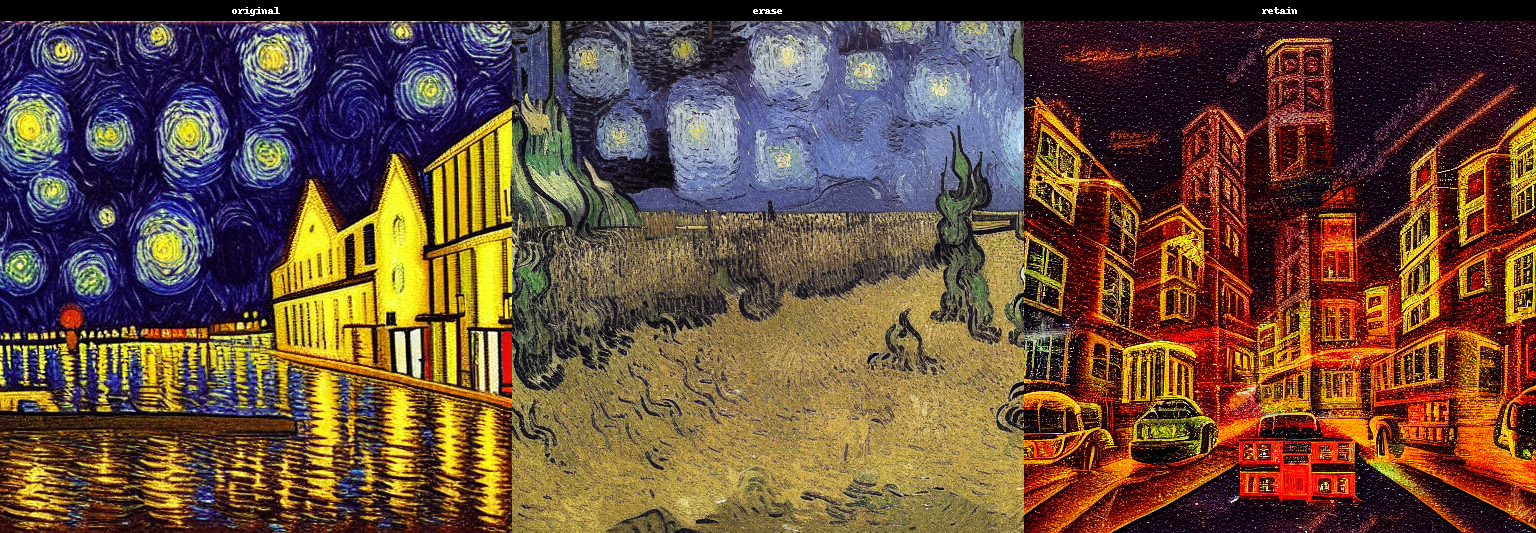

In [46]:
img_combined